In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics

file_path = './Speed_Dating_Data.csv' 
df = pd.read_csv(file_path,error_bad_lines=False)
df.iid = df.iid.astype(float)
df.pid = df.pid.astype(float)

# TODO: Intro
asdf intro stuff asdf (explain matches, attractiveness, etc.)

## Question: Are matches more common for people with similar attractivenesses?
asdf explain methodology and question and stuff asdf explain what we do below asdf

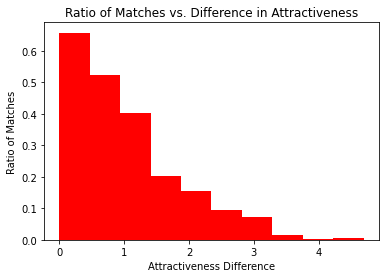

In [2]:
iids = pd.unique(df.iid)

# Assigns every unique person (by their iid) an attractiveness score based on the average of what their partners rated them
personToAttractiveness = {}
for subjectOfInterest in iids:
    attractiveness = statistics.mean(df[(df.iid == subjectOfInterest) & (df.attr_o.notna())].attr_o)
    personToAttractiveness[subjectOfInterest] = attractiveness

# Constructs a dictionary of pairs (tuple of iid and pid) to whether they matched
pairToDidMatch = {}
rowsWithPairs = df[df.iid.notna() & df.pid.notna()]
for iid in iids:
    for pid in rowsWithPairs[rowsWithPairs.iid == iid].pid:
        if (pid, iid) in pairToDidMatch:
            # Asserts that if person A matches with person B, then person B has also matched with person A
            assert rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match == pairToDidMatch[(pid, iid)]
            continue
        pairToDidMatch[(iid, pid)] = rowsWithPairs[(rowsWithPairs.iid == iid) & (rowsWithPairs.pid == pid)].iloc[0].match
        
# Gets all the differences of attractivenesses between people of all pairings and also collects whether the pair matched
attractivenessDifferences = [abs(personToAttractiveness[pair[0]] - personToAttractiveness[pair[1]]) for pair in pairToDidMatch.keys()]
correspondingDidMatch = list(pairToDidMatch.values())

# Gets the attractivness difference of people who matched
attractivenessDifferencesOfMatchers = []
for i in range(len(correspondingDidMatch)):
    if correspondingDidMatch[i] == 0:
        continue
    attractivenessDifferencesOfMatchers.append(attractivenessDifferences[i])

# Plots a density histogram of people who matched where the bins are of their attractiveness difference
plt.figure()
plt.hist(attractivenessDifferencesOfMatchers, density=True, color="red")
plt.title("Ratio of Matches vs. Difference in Attractiveness")
plt.xlabel("Attractiveness Difference")
plt.ylabel("Ratio of Matches")
plt.show()

### Analysis
TODO: explain the above data/chart

## Question: Do attractive people match more?
asdf explain methodology and question and stuff asdf

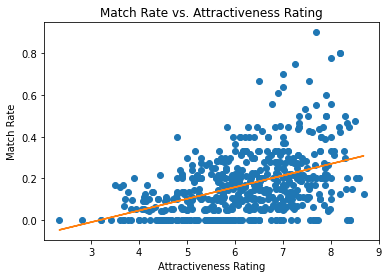

Linear Regression Equation: y =    0.05579x +   -0.17657.


In [3]:
# Gets a list of attractivenesses of all people and calculates the proportion of matches they made
attractivenesses = list(personToAttractiveness.values())
correspondingMatchRate = []
for subjectOfInterest in iids:
    rowsOfPerson = df[(df.iid == subjectOfInterest) & (df.pid.notna())]
    matchSuccessRate = len(rowsOfPerson[rowsOfPerson.match == 1]) / len(rowsOfPerson)
    correspondingMatchRate.append(matchSuccessRate)

# Linear regression
linearRegressionCoefficients = np.polyfit(attractivenesses, correspondingMatchRate, 1)
lineFunction = np.poly1d(linearRegressionCoefficients)

# Plots a scatter plot of attractiveness rating and match rate with the corresponding linear regression
plt.figure()
plt.plot(attractivenesses, correspondingMatchRate, "o", attractivenesses, lineFunction(attractivenesses), "-")
plt.title("Match Rate vs. Attractiveness Rating")
plt.xlabel("Attractiveness Rating")
plt.ylabel("Match Rate")
plt.show()

# Prints the linear regression equation
print("Linear Regression Equation: y = {:10.5f}x + {:10.5f}.".format(*linearRegressionCoefficients))

### Analysis
TODO: explain the above data/chart

## Question: TODO:
asdf